In [ ]:
import pandas as pd

In [ ]:
import numpy as np

In [ ]:
cellTypes = pd.read_csv("/content/drive/MyDrive/cellTypes.csv")

In [ ]:
cellTypes

,sampleID,batchID,clTopLevel,clMidwayPr,cl295v11SubShort,cl295v11SubFull
0,C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT,C103_T_1_1_0_c1_v2,Epi,Epi,cE01,cE01 (Stem/TA-like)
1,C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT,C103_T_1_1_0_c1_v2,Epi,Epi,cE01,cE01 (Stem/TA-like)
2,C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG,C103_T_1_1_0_c1_v2,Epi,Epi,cE03,cE03 (Stem/TA-like prolif)
3,C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT,C103_T_1_1_0_c1_v2,Epi,Epi,cE01,cE01 (Stem/TA-like)
4,C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC,C103_T_1_1_0_c1_v2,Epi,Epi,cE01,cE01 (Stem/TA-like)
...,...,...,...,...,...,...
370110,C173_T_0_0_0_c1_v3_id-TTTGGAGTCATCGGGC,C173_T_0_0_0_c1_v3,Myeloid,Macro,cM02,cM02 (Macrophage-like)
370111,C173_T_0_0_0_c1_v3_id-TTTGGAGTCTAGTGTG,C173_T_0_0_0_c1_v3,Epi,Epi,cE03,cE03 (Stem/TA-like prolif)
370112,C173_T_0_0_0_c1_v3_id-TTTGTTGCAGCAATTC,C173_T_0_0_0_c1_v3,Epi,Epi,cE03,cE03 (Stem/TA-like prolif)
370113,C173_T_0_0_0_c1_v3_id-TTTGTTGGTTCTGAGT,C173_T_0_0_0_c1_v3,TNKILC,TCD4,cTNI08,cTNI08 (CD4+ Treg)


In [ ]:
cellTypes["sample_type"] = cellTypes["batchID"].str.split("_").str[1]

In [ ]:
cellTypes = cellTypes[cellTypes["sample_type"] == "T"]

In [ ]:
proportions = pd.DataFrame(data = cellTypes[cellTypes["batchID"] == cellTypes["batchID"].unique()[0]]['cl295v11SubFull'].value_counts(normalize=True) * 100).rename(columns={'cl295v11SubFull': cellTypes["batchID"].unique()[0]})

In [ ]:
for i in range(len(cellTypes["batchID"].unique())):
    if i != 0:
        df = pd.DataFrame(data = cellTypes[cellTypes["batchID"] == cellTypes["batchID"].unique()[i]]['cl295v11SubFull'].value_counts(normalize=True) * 100).rename(columns={'cl295v11SubFull': cellTypes["batchID"].unique()[i]})
        proportions = pd.concat([proportions, df], axis=1, join="outer")

In [ ]:
proportions=proportions.T

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


In [ ]:
from scipy.stats import kendalltau, pearsonr, spearmanr

def kendall_pval(x,y):
  return kendalltau(x,y)[1]
    
def pearsonr_pval(x,y):
  return pearsonr(x,y)[0]
    
def spearmanr_pval(x,y):
  return spearmanr(x,y)[1]

In [ ]:
corr = proportions[proportions.columns[proportions.isnull().mean() < 0.66]].corr()

In [ ]:
import numpy as np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


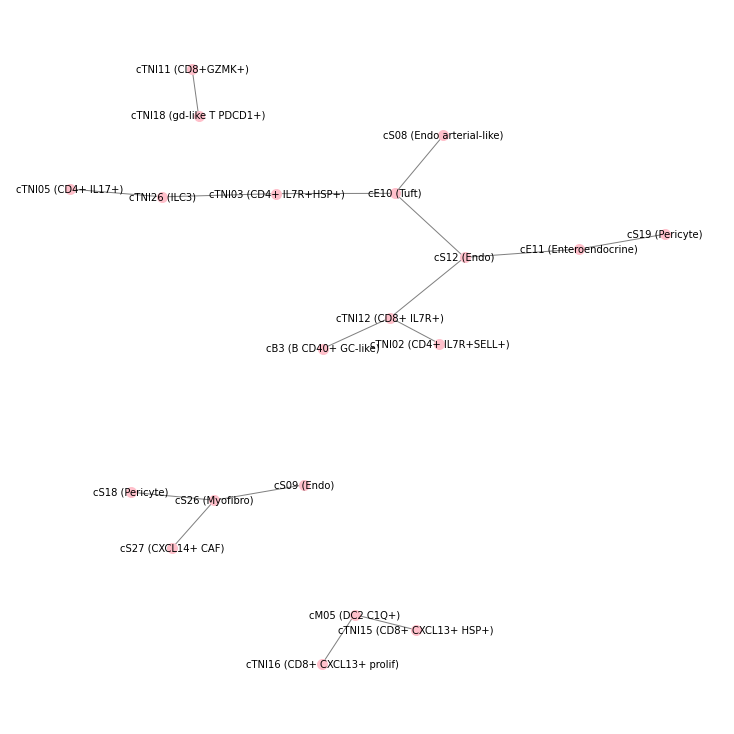

In [ ]:
links = corr.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
 
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ ((links['value'] > 0.3)) & (links['var1'] != links['var2']) ]

p_values = []
for i in links_filtered.index:
  x = np.array(list(proportions.loc[:,links_filtered.loc[i]["var1"]]))
  Y = np.array(list(proportions.loc[:,links_filtered.loc[i]["var2"]]))
  bad = ~np.logical_or(np.isnan(x), np.isnan(Y))
  p_values.append(kendalltau(np.compress(bad, x),np.compress(bad, Y))[0])
links_filtered["p_values"] = p_values


links_filtered = links_filtered[links_filtered["p_values"]<0.05]
#links_filtered["var1"] = links_filtered["var1"].str.split(" ").str[0]
#links_filtered["var2"] = links_filtered["var2"].str.split(" ").str[0]
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
 
# Plot the network:
pos = nx.spring_layout(G, k=0.18, iterations=20)
plt.figure(3,figsize=(10,10)) 
nx.draw(G, pos, with_labels=True, node_color='pink', node_size=100, edge_color='grey', linewidths=1, font_size=10)
plt.show()

In [ ]:
import numpy as np

In [ ]:
proportions = proportions.fillna(0)

In [ ]:
import sklearn

In [ ]:
proportions.shape

(120, 87)

In [ ]:
from sklearn.metrics import mutual_info_score

def calc_MI(l, m, bins):
    l = np.array(list(l))
    m = np.array(list(m))
    bad = ~np.logical_or(np.isnan(l), np.isnan(m))
    c_xy = np.histogram2d(np.compress(bad, l), np.compress(bad, m), bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

bins = 9 # ?
n = 87
matMI = np.zeros((n, n))

for ix in np.arange(n):
    for jx in np.arange(ix+1,n):
        matMI[ix,jx] = calc_MI(proportions.iloc[:,ix], proportions.iloc[:,jx], bins)

In [ ]:
matMI = matMI + matMI.T - np.diag(np.diag(matMI))

In [ ]:
MI = pd.DataFrame(matMI, columns = proportions.columns, index = proportions.columns)

In [ ]:
MI.mean().mean()

0.1118113967838758

In [ ]:
MI[MI > 0.1].count().sum()

2702

In [ ]:
import networkx as nx

In [ ]:
import matplotlib.pyplot as plt


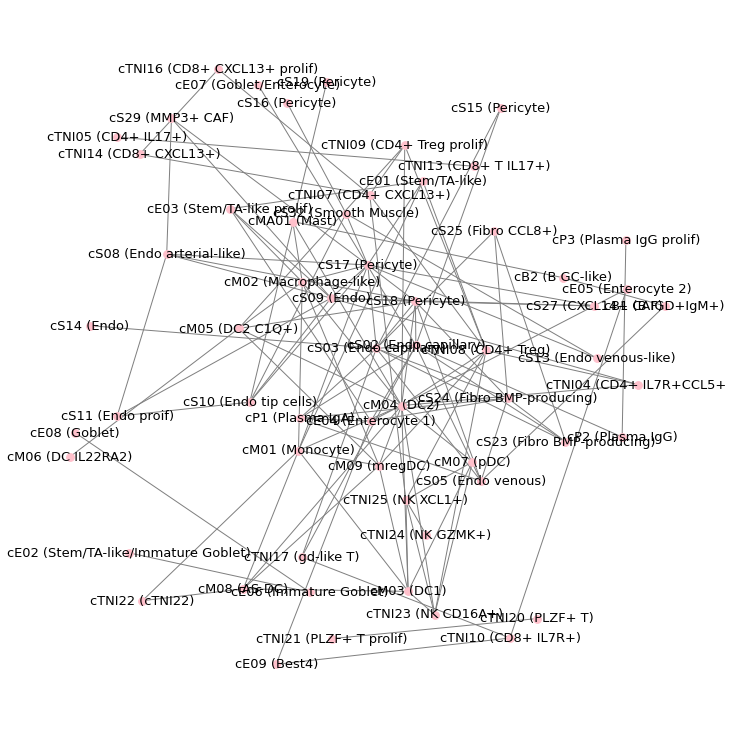

In [ ]:
links = MI.stack().reset_index()
links.columns = ['var1', 'var2', 'value']
 
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ ((links['value'] > 0.25)) & (links['var1'] != links['var2']) ]

#links_filtered["var1"] = links_filtered["var1"].str.split(" ").str[0]
#links_filtered["var2"] = links_filtered["var2"].str.split(" ").str[0]
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2')
 
# Plot the network:
pos = nx.spring_layout(G, k=0.6, iterations=28)
plt.figure(3,figsize=(10,10)) 
nx.draw(G, pos, with_labels=True, node_color='pink', node_size=60, edge_color='gray', linewidths=1, font_size=13, font_color="black")
plt.show()

In [ ]:
!pip install igraph

     |████████████████████████████████| 3.1 MB 5.5 MB/s 


In [ ]:
nodes = [i for i in G.nodes]
MIneighbors = pd.DataFrame({"nodes":nodes})
MIneighbors["neighbors"] = [[i for i in G.neighbors(j)] for j in nodes]

In [ ]:
# 1(1) - ok, 8(22):0.67 - ok, 28:0.55 - ok, 31 - ok, 33 - ok, 34 - ok, 38 - ok, 42- bad, 50 - ok, 53-ok, 54(1) - ok, 55(8) -OK
# 58(3) - good, 59(2) - ok, 61(5) - ok?, 65(17) - good(shap), 4(15) - bad, 21(2) - ok, 22(76)(336, 0.5) - bad, 28(54) - bad, 30(6266) - ok, 

In [ ]:
import numpy as np

In [ ]:
proportions = proportions.fillna(0)

In [ ]:
!pip install shap==0.34.0

     |████████████████████████████████| 264 kB 4.2 MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp37-cp37m-linux_x86_64.whl size=384428 sha256=4a7dabceb48f84e6b41eb0ac292f707e64b73328700aa6d0df9831eb5e8b0960
  Stored in directory: /root/.cache/pip/wheels/05/86/23/2c22a86fb2ba700382f20e1dbe536e211b3b1578aecc8adfac
Successfully built shap


In [ ]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import matplotlib.pylab as pl

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [ ]:
MIneighbors.loc[MIneighbors["neighbors"].map(len)>1]["neighbors"].apply(len).count()

47

In [ ]:
features = list(MIneighbors.loc[MIneighbors["neighbors"].map(len)>1]["neighbors"])[38]
prediction = list(MIneighbors.loc[MIneighbors["neighbors"].map(len)>1]["nodes"])[38]
X = proportions[features]
y = proportions[prediction]
X.index = y.index
X = X[y!=0]
y = np.array(y[y!=0])

In [ ]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = scaler.fit_transform(y.reshape(-1, 1))
y = np.array([item for sublist in list(y) for item in sublist])
#scaler = MinMaxScaler()
#X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
#y = scaler.fit_transform(y.reshape(-1, 1))
#y = np.array([item for sublist in list(y) for item in sublist])

In [ ]:
prediction

'cE06 (Immature Goblet)'

In [ ]:
list(MIneighbors.loc[MIneighbors["neighbors"].map(len)>4]["nodes"]).index(prediction)

ValueError: ignored

In [ ]:
#0(234), 1(234), 2(3), 6(3796), 7(279356), 10(756),15(54457455), 16(27524689), 17(586), 22(866) 25(56798), 26(dep2, 56798), /sub0.3 31(37353), 32([39322, 67358, 40388]), 33(13664, [8437, 85978] bad), 
# 34(50369), 35([15538, 33390, 81570, 16294, 13184]), 36(58684), 37([74501, 18294, 40440, 55445, 26075, 74897])

In [ ]:
keys = []


In [ ]:
keys

[]

In [ ]:
keys = []
for i in range(5000):
  x=np.random.randint(0,100000)
  X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=x)
  model= xgboost.XGBRegressor(max_depth=3, learning_rate=0.05, subsample=0.3, n_estimators=5000, gamma=0)
  model.fit(X_train, y_train, eval_set=[(X_test,y_test)], eval_metric="rmse", verbose=0, early_stopping_rounds=100)
  if (min(model.evals_result()['validation_0']['rmse']) < 0.5):
    if ((abs((y_test)-model.predict(X_test))/abs(y_test)).mean() < 0.6):
      keys.append(x)
keys

[23:51:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:51:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=74897)
model= xgboost.XGBRegressor(max_depth=3, learning_rate=0.05, subsample=0.3, n_estimators=5000, gamma=0)
model.fit(X_train, y_train, eval_set=[(X_test,y_test)], eval_metric="rmse", verbose=100, early_stopping_rounds=100)

[23:35:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.20561
Will train until validation_0-rmse hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.464732
[200]	validation_0-rmse:0.44485
Stopping. Best iteration:
[161]	validation_0-rmse:0.415308



XGBRegressor(learning_rate=0.05, n_estimators=5000, subsample=0.3)

In [ ]:
16043

In [ ]:
preds =model.predict(X)

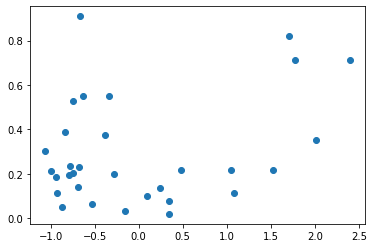

In [ ]:
plt.figure()
plt.scatter(y, abs(preds-y))
plt.show()

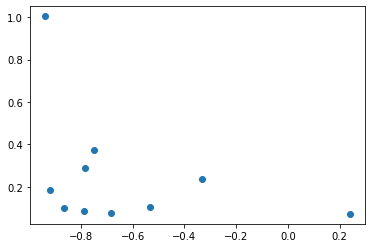

In [ ]:
plt.figure()
plt.scatter(y_test, abs(model.predict(X_test)-y_test))
plt.show()

In [ ]:
y_test

array([-0.28158444, -0.92166085, -0.68555433, -0.38251023, -0.74876861,
       -0.78688208,  1.52000603, -0.5333829 ,  1.04890261, -0.15538525])

In [ ]:
model.predict(X_test)

array([-0.18587023, -0.8517797 , -0.71247554, -0.40677434, -0.9492984 ,
       -1.074389  ,  1.0805757 , -0.46263194,  0.6783578 , -0.14396667],
      dtype=float32)

In [ ]:
abs((y_test)-model.predict(X_test))

array([0.09571421, 0.06988115, 0.02692121, 0.02426411, 0.20052977,
       0.2875069 , 0.43943033, 0.07075096, 0.37054483, 0.01141857])

In [ ]:
(abs((y_test)-model.predict(X_test))).mean()

0.15969620373187102

In [ ]:
(abs((y_test)-model.predict(X_test))/abs(y_test)).mean()

0.4736528313319302

In [ ]:
(abs(abs((y_test)-model.predict(X_test))/abs(y_test)).std()

SyntaxError: ignored

In [ ]:
1/(0.613837/(y.max()-y.min()))

7.824911314927835

In [ ]:
import sklearn

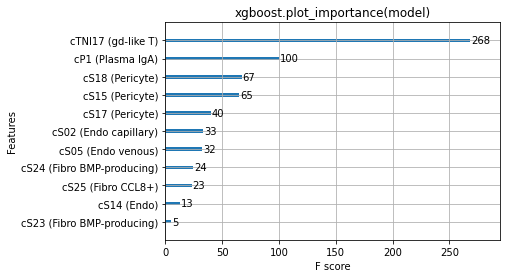

In [ ]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

In [ ]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


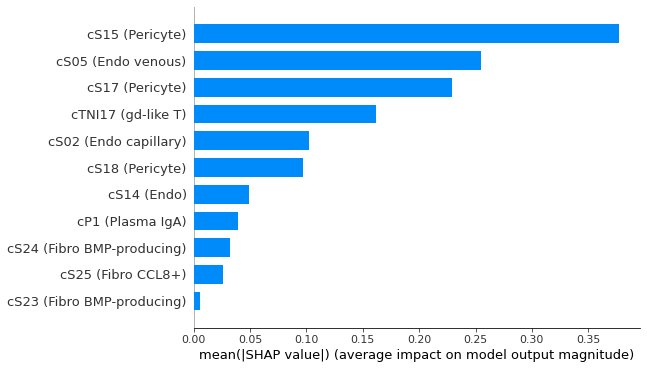

In [ ]:
shap.summary_plot(shap_values, X, plot_type="bar")


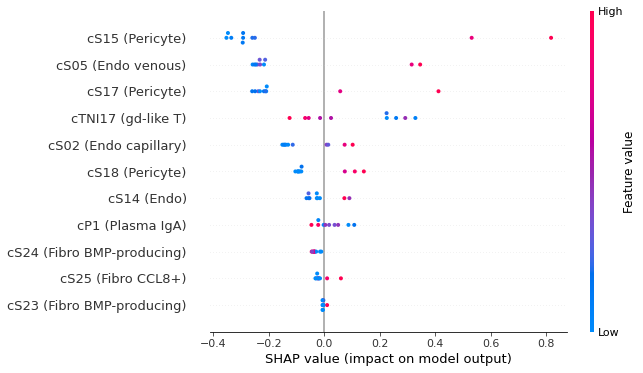

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap_values

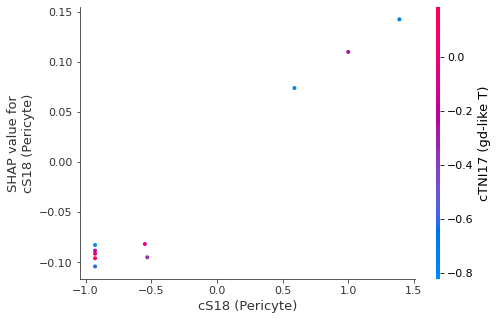

In [ ]:
shap.dependence_plot(2, shap_values, X_test)

In [ ]:
shap.initjs()


In [ ]:
e3 = shap.TreeExplainer(model)
t = e3.shap_values(X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
shap.initjs()
shap.force_plot(e3.expected_value, shap_values[0,:], X.loc[0,:])

In [ ]:
shap.initjs()
shap.force_plot(e3.expected_value, shap_values[:,:], X.loc[:,:])

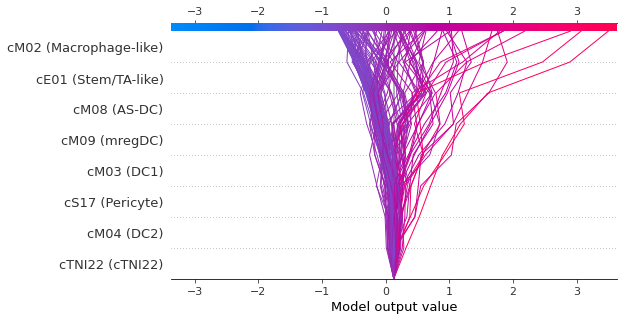

In [ ]:
shap.initjs()
shap.decision_plot(e3.expected_value, shap_values[:,:], X.loc[:,:])

In [ ]:
!pip install matplotlib==3.1.1